**This Notebook...**


- clips parts of Europe for more in-depth analysis (- runs on the kernel `spatial-analysis` on owl2intel (rasterio does not seem to work on levante))
    - creates plots
    - statistics with the harveted area

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import datetime as dt
import seaborn as sns
sns.set_context("notebook")
import glob
import os

import dicts
import home
import importlib
importlib.reload(home)

import geopandas as gpd
import rasterio as rio
%matplotlib inline

## Get clipped parts 

In [35]:
data = home.hspath

In [1]:
#nc_file = xr.open_dataset("../output/scenic_f2017_HI_maize_rf_2023-09-11.nc")
nuts0 = data = gpd.read_file(f"{home.hshome}/shapefiles/eurnuts0.shp")
# For shapefile:
subset = nuts0[np.isin(nuts0.NAME,["ROMANIA","BULGARIJA","MAGYARORSZAG","SHQIPERI","ELLADA",])]
subset.set_crs('epsg:4326', inplace = True, allow_override = True)

NameError: name 'gpd' is not defined

In [37]:
def clipCountries(ds,list_countries):
    nc_file = ds
    nuts0 = gpd.read_file("../shapefiles/eurnuts0.shp")
    # For shapefile:
    subset = nuts0[np.isin(nuts0.NAME,list_countries)]
    subset = subset.set_crs('epsg:4326', allow_override = True)

    nc_file = nc_file.rio.set_spatial_dims("lon","lat",inplace=True)
    nc_file = nc_file.rio.write_crs(subset.crs)
    clip  = nc_file.rio.clip(subset.geometry,drop = True)
    return clip
countries_southeast = ["ROMANIA","BULGARIJA","MAGYARORSZAG","ELLADA","SLOVENIJA","SLOVENSKA REPUBLIKA","SRBIJA","ROMANIA","MAKEDONIJA","MOLDOVIA","CRNA GORA","HRAVATSKA","BOSNA I HERCEGOVINA","SHQIPERI"]
countries_balkan = ["ROMANIA","BULGARIJA","MAGYARORSZAG","ELLADA"]
countries_iberia = ["PORTUGAL","ESPANA"]
countries_midEU = ["SCHWEIZ","FRANCE","DEUTSCHLAND","ÖSTERREICH","ITALIA"]


### Define Clip 

In [61]:
watering = "rf"
crop = "maize"

HI_all = []
scenarios = [2017,2038,2065,2093]
#clip_extend = [slice(35.125,48.375),slice(16.375,29.625)]
for scenario in scenarios: 
    HI_file = sorted(glob.glob(f"{home.hspath}/HI_final/ggcmi_planting/scenic_EU025_f{scenario}_HI_{crop}_{watering}*.nc"), key=os.path.getmtime)[-1]
    HI = xr.open_dataset(HI_file)
    HI = HI.sel(year = slice(scenario+1,scenario+5))
    HI["year_id"] = HI.year-scenario
    HI_all.append(HI)

HI_all = xr.concat(HI_all,dim="year")

clip = clipCountries(HI_all,countries_southeast)


In [62]:
#save on owl
clip.to_netcdf(f"{home.hspath}/HI_final/clip/scenic_clip_HI_{crop}.nc")

---


In [130]:
# open on levante
crop = "maize"
clip = xr.load_dataset(f"{home.hspath}/HI_final/clip/scenic_clip_HI_{crop}.nc")

In [4]:
clip_21 = clip.where(clip.year_id==4,drop=True)

### Plot Clip 

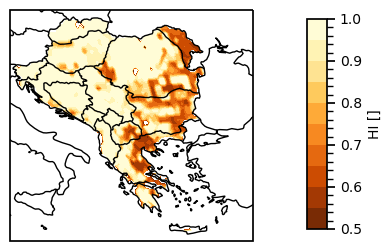

In [9]:
fig, axs = plt.subplots( figsize=(4, 3),subplot_kw={"projection": ccrs.Orthographic(5,15)})



data = clip_21.HI.sel(year=2021)
plot = axs.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap="YlOrBr_r",levels = np.linspace(0.5,1,11))
axs.coastlines();
axs.add_feature(cartopy.feature.BORDERS)
#cbar = plt.colorbar(plot,pad=0.05)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7]) #4-tuple of floats rect = [left, bottom, width, height]
#[0.95, 0.15, 0.05, 0.7]
cbar = fig.colorbar(plot,cax=cbar_ax,pad=0.5)
cbar.set_label('HI []',  rotation=90,fontsize=10)
cbar.ax.tick_params(labelsize=10)
cbar.minorticks_on()

In [10]:
clip_extend = [slice(clip.lat.min(),clip.lat.max()),slice(clip.lon.min(),clip.lon.max())]
#clip_extend = [slice(35.125,48.375),slice(16.375,29.625)]
clip_extend

[slice(<xarray.DataArray 'lat' ()>
 array(35.125), <xarray.DataArray 'lat' ()>
 array(49.375), None),
 slice(<xarray.DataArray 'lon' ()>
 array(13.625), <xarray.DataArray 'lon' ()>
 array(29.875), None)]

In [112]:
deg_list = ["present day"]*6 + ["+2K"]*6 + ["+3K"] *6 + ["+4K"]*6
name_list =["ggcmi"]*6 + [2038, 2039, 2040, 2041, 2042, 2043] +[2065, 2066, 2067, 2068, 2069, 2070] +[2093, 2094, 2095, 2096, 2097, 2098]
year_list = list(np.linspace(2017,2022,6)) + [2038, 2039, 2040, 2041, 2042, 2043] +[2065, 2066, 2067, 2068, 2069, 2070] +[2093, 2094, 2095, 2096, 2097, 2098]

scen_list = [2017]*6 + [2038]*6 + [2065]*6+ [2093]*6
name_dict = dict(zip(name_list,deg_list)) 
year_dict = dict(zip(year_list,deg_list))
scen_dict = dict(zip(scen_list,deg_list))

In [ ]:
import numpy as np

d = {1:10, 2:20, 3:30, 4:50}
arr = np.array([1, 2, 3, 4])

result = np.vectorize(lambda k: d[k])(arr)

In [117]:
clip.year

<xarray.DataArray 'year' (year: 20)>
array([2018, 2019, 2020, 2021, 2022, 2039, 2040, 2041, 2042, 2043, 2066, 2067,
       2068, 2069, 2070, 2094, 2095, 2096, 2097, 2098])
Coordinates:
  * year     (year) int64 2018 2019 2020 2021 2022 ... 2094 2095 2096 2097 2098
Attributes:
    standard_name:  year
    axis:           T

In [131]:
forcing = np.vectorize(lambda k: year_dict[k])(clip.year)

In [129]:
clip

<xarray.Dataset>
Dimensions:      (lat: 58, lon: 66, year: 20, forcing: 20)
Coordinates:
  * lat          (lat) float64 35.12 35.38 35.62 35.88 ... 48.88 49.12 49.38
  * lon          (lon) float64 13.62 13.88 14.12 14.38 ... 29.38 29.62 29.88
  * year         (year) int64 2018 2019 2020 2021 2022 ... 2095 2096 2097 2098
  * forcing      (forcing) <U11 'present day' 'present day' ... '+4K' '+4K'
Data variables:
    spatial_ref  int64 0
    HI           (lat, lon, year) float64 nan nan nan nan ... nan nan nan nan
    year_id      (year) int64 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5
Attributes:
    forcing:          f2017
    grid resolution:  0.25
    creation date:    2023-11-29 12:08:04
    script:           ../Scripts/heatstress.py
    contact:          lioba.martin@kit.edu

In [127]:
forcing

array(['present day', 'present day', 'present day', 'present day',
       'present day', '+2K', '+2K', '+2K', '+2K', '+2K', '+3K', '+3K',
       '+3K', '+3K', '+3K', '+4K', '+4K', '+4K', '+4K', '+4K'],
      dtype='<U11')

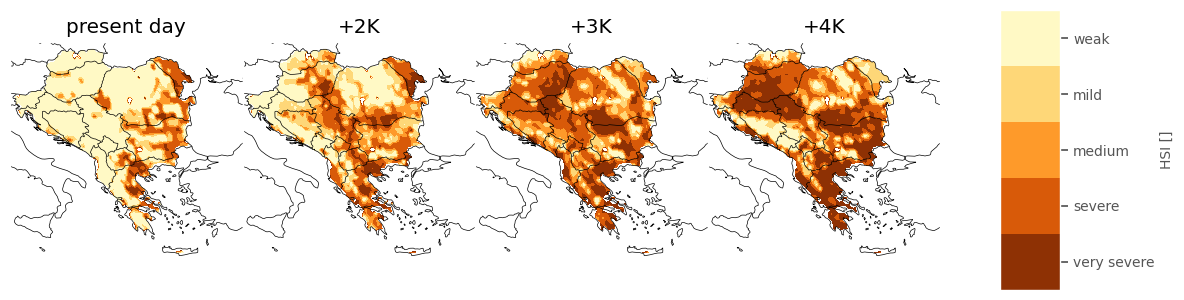

In [6]:
fig, axs = plt.subplots( figsize=(12,4),ncols=4,subplot_kw={"projection": ccrs.Orthographic(5,15)})
plt.subplots_adjust(wspace=0, hspace=0)
plt.style.use("ggplot")
for ax,year in zip(axs.flat,clip_21.year.values):
    data = clip_21.HI.sel(year=year)
    plot = ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap="YlOrBr_r",levels = np.linspace(0.5,1,6))
    ax.coastlines();
    ax.add_feature(cartopy.feature.BORDERS)
    ax.set_facecolor("white")
    ax.set_title(f"{year_dict[year]}\n{year}")
#cbar = plt.colorbar(plot,pad=0.05)
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7]) #4-tuple of floats rect = [left, bottom, width, height]
#[0.95, 0.15, 0.05, 0.7]
cbar = fig.colorbar(plot,cax=cbar_ax,pad=0.5)
cbar.set_label('HSI []',  rotation=90,fontsize=10)
cbar.ax.tick_params(labelsize=10)
cbar.set_ticks(np.linspace(0.55,0.95,5))
cbar.set_ticklabels(['very severe', 'severe', 'medium','mild','weak'])
plt.savefig(f"{home.hsplot}/clip/HI_{crop}_2021.png",dpi=300,bbox_inches='tight')

In [147]:
clip_df = clip.assign_coords(forcing=("year", forcing)).swap_dims({"year":"forcing"}).HI.to_dataframe().reset_index("forcing")

<AxesSubplot:xlabel='year', ylabel='HI'>

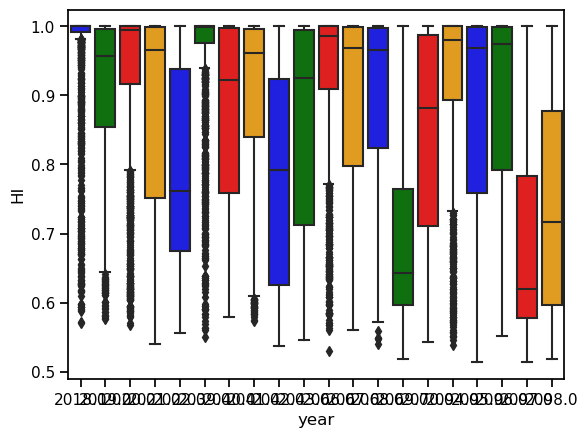

In [149]:
sns.boxplot(data= clip_df.where(clip_df.HI>0),x = "year",y="HI",palette=colors)

In [156]:
clip_df.groupby("forcing").mean(...)

year        HI
forcing                      
+2K          2041.0  0.848039
+3K          2068.0  0.825137
+4K          2096.0  0.797261
present day  2020.0  0.866307

In [30]:
clip.HI.groupby("year").mean(...).to_dataframe()

HI
year          
2018  0.935433
2019  0.882613
2020  0.904145
2021  0.845484
2022  0.763861
2039  0.930719
2040  0.850561
2041  0.876791
2042  0.753687
2043  0.828437
2066  0.904236
2067  0.868471
2068  0.869386
2069  0.665709
2070  0.817884
2094  0.900041
2095  0.849287
2096  0.864391
2097  0.658189
2098  0.714397

In [87]:
clip

<xarray.Dataset>
Dimensions:      (lat: 58, lon: 66, year: 20)
Coordinates:
  * lat          (lat) float64 35.12 35.38 35.62 35.88 ... 48.88 49.12 49.38
  * lon          (lon) float64 13.62 13.88 14.12 14.38 ... 29.38 29.62 29.88
  * year         (year) int64 2018 2019 2020 2021 2022 ... 2095 2096 2097 2098
Data variables:
    spatial_ref  int64 0
    HI           (lat, lon, year) float64 nan nan nan nan ... nan nan nan nan
    year_id      (year) int64 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5
Attributes:
    forcing:          f2017
    grid resolution:  0.25
    creation date:    2023-11-29 12:08:04
    script:           ../Scripts/heatstress.py
    contact:          lioba.martin@kit.edu

In [88]:
clip_df = clip.set_coords("year_id").swap_dims({"year":"year_id"}).HI.to_dataframe().reset_index("year_id")
clip_df.to_csv(f"{home.hspath}/HI_final/clip/scenic_clip_HI_maize.csv")

In [92]:
clip_df.where(clip_df.HI>0)

year_id  year  HI
lat    lon                      
35.125 13.625      NaN   NaN NaN
       13.625      NaN   NaN NaN
       13.625      NaN   NaN NaN
       13.625      NaN   NaN NaN
       13.625      NaN   NaN NaN
...                ...   ...  ..
49.375 29.875      NaN   NaN NaN
       29.875      NaN   NaN NaN
       29.875      NaN   NaN NaN
       29.875      NaN   NaN NaN
       29.875      NaN   NaN NaN

[76560 rows x 3 columns]

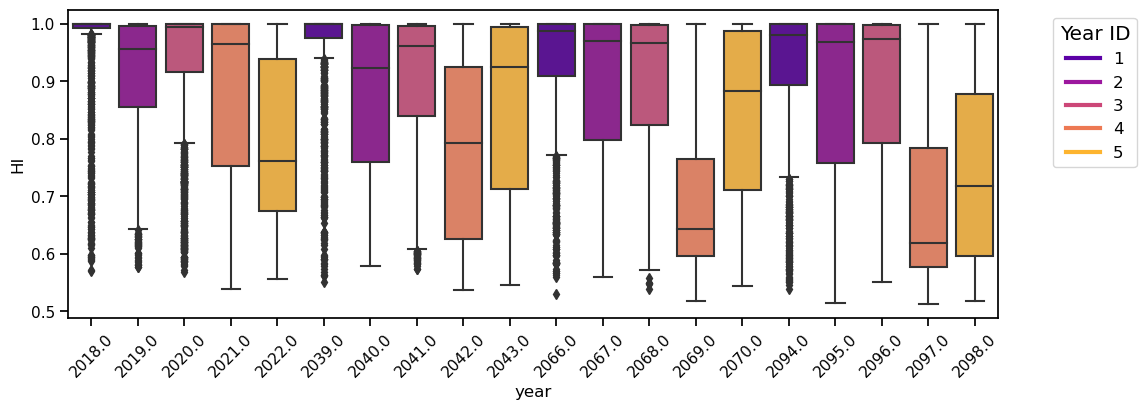

In [101]:
from matplotlib.lines import Line2D
colors = sns.color_palette("plasma", 25 // 5)
plt.figure(  figsize=(12, 4))
sns.boxplot(data= clip_df.where(clip_df.HI>0),x = "year",y="HI",palette=colors)

plt.xticks(rotation=45)

legend_labels = [1,2,3,4,5]


legend_handles = [Line2D([0], [0], color=color, linewidth=3, label=label) 
                  for color, label in zip(colors, legend_labels)]
plt.legend(handles=legend_handles, title='Year ID', title_fontsize='large', fontsize='medium',bbox_to_anchor=(1.05, 1), loc='upper left')
#sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
#ax.axvline(2023, color=".3", dashes=(2, 2))

In [31]:
clip.set_coords("year_id").swap_dims({"year":"year_id"})

<xarray.Dataset>
Dimensions:      (lat: 58, lon: 66, year_id: 20)
Coordinates:
  * lat          (lat) float64 35.12 35.38 35.62 35.88 ... 48.88 49.12 49.38
  * lon          (lon) float64 13.62 13.88 14.12 14.38 ... 29.38 29.62 29.88
    year         (year_id) int64 2018 2019 2020 2021 ... 2095 2096 2097 2098
  * year_id      (year_id) int64 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5
Data variables:
    spatial_ref  int64 0
    HI           (lat, lon, year_id) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    forcing:          f2017
    grid resolution:  0.25
    creation date:    2023-11-29 12:08:04
    script:           ../Scripts/heatstress.py
    contact:          lioba.martin@kit.edu

In [37]:
clip

<xarray.Dataset>
Dimensions:      (lat: 58, lon: 66, year: 20)
Coordinates:
  * lat          (lat) float64 35.12 35.38 35.62 35.88 ... 48.88 49.12 49.38
  * lon          (lon) float64 13.62 13.88 14.12 14.38 ... 29.38 29.62 29.88
  * year         (year) int64 2018 2019 2020 2021 2022 ... 2095 2096 2097 2098
Data variables:
    spatial_ref  int64 0
    HI           (lat, lon, year) float64 nan nan nan nan ... nan nan nan nan
    year_id      (year) int64 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5 1 2 3 4 5
Attributes:
    forcing:          f2017
    grid resolution:  0.25
    creation date:    2023-11-29 12:08:04
    script:           ../Scripts/heatstress.py
    contact:          lioba.martin@kit.edu

## get numbers with harvested area

In [5]:
harvest_area = xr.open_dataset(f"{home.hspath}/crop_areas/harvest_areas_EU_025.nc")

In [9]:
clip_severe = clip_21.HI.where((clip_21.HI < 0.6) & (clip_21.HI >= 0.5),drop=True)

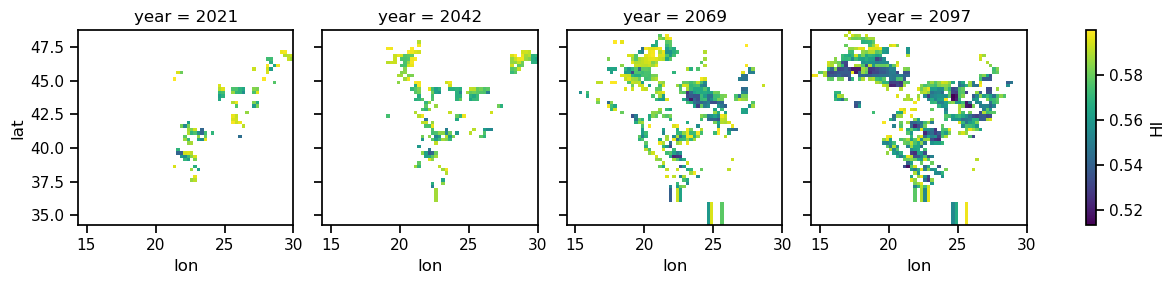

In [10]:
clip_severe.plot(col = "year")

In [11]:
limits = np.linspace(0.5,1.1,7)
print(limits)
levels = ["very severe","severe","strong","moderate","weak","not"]

levels_dict = dict(zip(levels,limits))
print(levels_dict)

[0.5 0.6 0.7 0.8 0.9 1.  1.1]
{'very severe': 0.5, 'severe': 0.6, 'strong': 0.7000000000000001, 'moderate': 0.8, 'weak': 0.9000000000000001, 'not': 1.0}


In [15]:
#(only 2021) 
df_levels=pd.DataFrame({"year":clip_21.year.values}).set_index("year")


for l in levels:
    df_levels[l] = np.nan
    for y in clip_21.year.values:
        mask = (clip_21.HI.sel(year=y) >= levels_dict[l]) &(clip_21.HI.sel(year=y) < (levels_dict[l]+0.1))
        if mask.sum().values != 0:
            area_y = harvest_area.sel(year=2021).where(mask,drop=True).rf_maize.sum()
        else: 
            area_y = xr.DataArray(0)
        df_levels.loc[y,l] = round((area_y.values/1000000),3)
        
df_levels["sum"] = df_levels.sum(axis=1)

print(df_levels)
## in Million ha 

      very severe  severe  strong  moderate   weak    not    sum
year                                                            
2021        0.403   1.308   0.480     0.616  3.645  0.070  6.522
2042        1.122   1.700   0.969     1.339  1.324  0.022  6.476
2069        2.106   2.459   0.911     0.634  0.342  0.002  6.454
2097        2.784   2.154   0.423     0.663  0.427  0.000  6.451


In [11]:
print(df_levels.to_latex(label="tab:harvestd_area_SEeurope",
                         caption="Harvested area for the different levels of heat stress in south-eastern Europe",
                        float_format="%.2f"))

\begin{table}
\caption{Harvested area for the different levels of heat stress in south-eastern Europe}
\label{tab:harvestd_area_SEeurope}
\begin{tabular}{lrrrrrr}
\toprule
 & very severe & severe & strong & moderate & weak & not \\
year &  &  &  &  &  &  \\
\midrule
2021 & 0.40 & 1.31 & 0.48 & 0.62 & 3.65 & 0.07 \\
2042 & 1.12 & 1.70 & 0.97 & 1.34 & 1.32 & 0.02 \\
2069 & 2.11 & 2.46 & 0.91 & 0.63 & 0.34 & 0.00 \\
2097 & 2.78 & 2.15 & 0.42 & 0.66 & 0.43 & 0.00 \\
\bottomrule
\end{tabular}
\end{table}



In [24]:
(df_levels[levels].div(df_levels["sum"],axis=0)*100)
#in % 

very severe     severe     strong   moderate       weak       not
year                                                                   
2021     6.179086  20.055198   7.359706   9.444956  55.887764  1.073290
2042    17.325510  26.250772  14.962940  20.676343  20.444719  0.339716
2069    32.630927  38.100403  14.115277   9.823365   5.299039  0.030989
2097    43.156100  33.390172   6.557123  10.277476   6.619129  0.000000

In [181]:

df_levels=pd.DataFrame({"year":clip.year.values}).set_index("year")


for l in levels:
    df_levels[l] = np.nan
    for y in clip.year.values:
        mask = (clip.HI.sel(year=y) >= levels_dict[l]) &(clip.HI.sel(year=y) < (levels_dict[l]+0.1))
        if mask.sum().values != 0:
            area_y = harvest_area.sel(year=2021).where(mask,drop=True).rf_maize.sum()
        else: 
            area_y = xr.DataArray(0)
        df_levels.loc[y,l] = round((area_y.values/1000000),3)
        
df_levels["sum"] = df_levels.sum(axis=1)

df_levels
## in Million ha 

very severe    severe    strong  moderate      weak       not       sum
year                                                                         
2018        9.935   141.656   248.208   300.178  5760.384  1791.741  8252.102
2019        1.064    33.396  1204.211  1145.747  4076.809   354.186  6815.413
2020        2.274   204.703   563.355   524.062  5169.269   996.114  7459.777
2021      403.108  1308.268   479.966   615.965  3644.912    69.986  6522.205
2022      713.288  1672.982  1939.906   800.208  1332.921    51.966  6511.271
2039        1.848    70.915   263.596   261.091  5862.913  1601.312  8061.675
2040      138.814   618.402  1924.422  1089.085  2690.505   285.516  6746.744
2041       14.764   413.168   760.112  1279.729  3995.889   393.509  6857.171
2042     1121.511  1699.864   968.529  1338.662  1323.652    22.145  6474.363
2043      367.376  1452.210  1182.964   734.550  2722.204    64.304  6523.608
2066        1.380    66.686   428.358  1137.964  4825.974   726.889  7187.251
2067      398.772   571.479  1337.831  1058.616  3094.529   230.537  6691.764
2068      135.093   939.039   412.558  1106.908  3870.063   205.526  6669.187
2069     2106.258  2458.765   910.741   634.156   342.300     2.132  6454.352
2070      622.756  1189.585   795.408  1029.283  2822.272    55.834  6515.138
2094        7.582   216.571   326.284  1287.703  4622.222   492.950  6953.312
2095      576.824   689.098   589.563   749.833  3855.909   166.312  6627.539
2096      296.065   821.661   471.772   424.849  4449.315   182.409  6646.071
2097     2784.104  2154.305   423.287   663.317   427.206     0.000  6452.219
2098     1594.224  1575.385  1212.593   948.948  1128.154    16.203  6475.507

In [182]:
df_levels[["very severe","severe"]].sum(axis=1)

year
2018     151.591
2019      34.460
2020     206.977
2021    1711.376
2022    2386.270
2039      72.763
2040     757.216
2041     427.932
2042    2821.375
2043    1819.586
2066      68.066
2067     970.251
2068    1074.132
2069    4565.023
2070    1812.341
2094     224.153
2095    1265.922
2096    1117.726
2097    4938.409
2098    3169.609
dtype: float64

In [180]:
print("mean area severly and very severely affected")
for s in [2017,2038,2065,2093]:
    print(f' in f{s}: {df_levels.loc[s:s+5][["very severe","severe"]].sum(axis=1).mean()} Mha')
    

mean area severly and very severely affected
 in f2017: 0.898 Mha
 in f2038: 1.1798 Mha
 in f2065: 1.698 Mha
 in f2093: 2.1431999999999998 Mha


In [180]:
print("mean area severly and very severely affected")
for s in [2017,2038,2065,2093]:
    print(f' in f{s}: {df_levels.loc[s:s+5][["very severe","severe"]].sum(axis=1).mean()} Mha')
    

mean area severly and very severely affected
 in f2017: 0.898 Mha
 in f2038: 1.1798 Mha
 in f2065: 1.698 Mha
 in f2093: 2.1431999999999998 Mha


In [26]:
(df_levels[levels].div(df_levels["sum"],axis=0)*100)
# in prozent %

very severe     severe     strong   moderate       weak        not
year                                                                    
2018     0.121183   1.720795   3.005332   3.635482  69.801260  21.715948
2019     0.014674   0.484226  17.666911  16.815847  59.823918   5.194424
2020     0.026813   2.748358   7.547929   7.025070  69.298834  13.352996
2021     6.179086  20.055198   7.359706   9.444956  55.887764   1.073290
2022    10.950699  25.694978  29.795730  12.286899  20.473046   0.798648
2039     0.024808   0.880675   3.274622   3.237410  72.723890  19.858596
2040     2.060175   9.159627  28.516378  16.140507  39.884393   4.238921
2041     0.218723   6.022164  11.081948  18.664334  58.267717   5.745115
2042    17.325510  26.250772  14.962940  20.676343  20.444719   0.339716
2043     5.626246  22.259696  18.135827  11.267822  41.729266   0.981144
2066     0.013914   0.932239   5.955197  15.834145  67.149019  10.115486
2067     5.961452   8.531301  19.991035  15.822501  46.242343   3.451367
2068     2.023988  14.077961   6.191904  16.596702  58.020990   3.088456
2069    32.630927  38.100403  14.115277   9.823365   5.299039   0.030989
2070     9.562548  18.265541  12.202609  15.794321  43.315426   0.859555
2094     0.115042   3.120506   4.687949  18.521714  66.465344   7.089445
2095     8.705492  10.395293   8.901629  11.315631  58.177429   2.504526
2096     4.453807  12.368342   7.102016   6.394824  66.942522   2.738489
2097    43.156100  33.390172   6.557123  10.277476   6.619129   0.000000
2098    24.617761  24.324324  18.733591  14.656371  17.420849   0.247104

In [97]:
l = "very severe"
levels_dict[l] +0.1

0.6

In [15]:
df_levels[["severe","very severe"]].div(df_levels.sum(axis=1),axis=0)

severe  very severe
year                       
2021  0.200552     0.061791
2042  0.262508     0.173255
2069  0.381004     0.326309
2097  0.333902     0.431561

In [14]:
df_levels.sum(axis=1)

year
2021    6.522
2042    6.476
2069    6.454
2097    6.451
dtype: float64

In [157]:
clip_17 = clip.where(clip.year_id==0,drop=True)